In [1]:
library(arcgisbinding, quietly = TRUE)
library(dismo, quietly = TRUE)
library(here, quietly = TRUE)
library(maxlike, quietly = TRUE)
library(raster, quietly = TRUE)
library(reticulate)

*** Please call arc.check_product() to define a desktop license.
Warning message:
"package 'raster' was built under R version 3.5.2"here() starts at Z:/Users/orhu8849/OneDrive - Esri/Documents/UC 2019/R Bridge Preconference


In [2]:
arc.check_product()

product: ArcGIS Pro ( 12.5.0.21044 )
license: Advanced 
version: 1.0.1.232

In [53]:
## Define the name of the geodatabase that contains the seagrass dataset
gdb.name <- 'seagrass.gdb'
## Create the full path to seagrass geodatabase
data.loc <- here("R-Bridge-Tutorial-Notebooks/data", gdb.name)
## Define contents of the Geodatabase
contents <- arc.open(data.loc)
print(contents)

dataset_type    : Container
path            : Z:/Users/orhu8849/OneDrive - Esri/Documents/UC 2019/R Bridge Preconference/R-Bridge-Tutorial-Notebooks/data/seagrass.gdb 
children        : FeatureClass[5], RasterDataset[3]
FeatureClass    : Major_Ports, EMU_Global_90m, US_coastline_shallow, bathymetrry_shallow, Seagrass_USA
RasterDataset   : EucDist_Majo1, EucDist_Majo3, EucDist_Majo4 


In [54]:
ARCPY <- import("arcpy")
## Set the Workspace to Avoid Defining the Long Paths for Every Arcpy Function
ARCPY$env$workspace = data.loc

In [55]:

#### Read in the Ecological Marine Units (EMU) Data to be Used for Interpolation
emu.data.loc <- 'EMU_Global_90m'
emu.data <- arc.select(arc.open(file.path(data.loc, emu.data.loc)))
head(emu.data, 3)

#### We will use the predictors temp, salinity, appO2ut, dissO2, nitrate, percO2sat, phosphate, silicate and srtm30
### We index these predictor names as they exist in EMU data set
predictor.names <- colnames(emu.data)[3:11]
print(predictor.names)

OBJECTID,pointid,temp,salinity,appO2ut,dissO2,nitrate,percO2sat,phosphate,silicate,...,GeomorphologyBase,SpecialCases,GeomorphologyFeatures,NameEMU,SurfaceArea,POINT_X,POINT_Y,ChlorA_12yrAvg,GeneralName,OceanName
4,1739,-1.600642,34.03786,1.1107794,7.211782,22.96304,86.85204,1.831893,67.54764,...,high Shelf,Both,NA,"Epipelagic, Frozen/Superchilled, Euhaline, Oxic, Medium Nitrate, Low Phosphate, Medium Silicate",163.6701,-159.625,-77.875,0.5956960,"Shallow, Frozen, Normal Salinity, Moderate Oxygen, Medium Nitrate, Low Phosphate, Medium Silicate",Southern
5,1740,-1.562380,34.02853,0.9979190,7.310482,21.98382,88.18443,1.807824,67.57066,...,high Shelf,Both,NA,"Epipelagic, Frozen/Superchilled, Euhaline, Oxic, Medium Nitrate, Low Phosphate, Medium Silicate",163.6701,-159.375,-77.875,0.3886366,"Shallow, Frozen, Normal Salinity, Moderate Oxygen, Medium Nitrate, Low Phosphate, Medium Silicate",Southern
19,3297,-1.205610,34.44400,-0.7813388,8.905671,13.62657,109.83964,1.296794,66.05339,...,NA,Bottom,NA,"Epipelagic, Frozen/Superchilled, Euhaline, Oxic, Medium Nitrate, Low Phosphate, Medium Silicate",163.6701,165.875,-77.875,NA,"Shallow, Frozen, Normal Salinity, Moderate Oxygen, Medium Nitrate, Low Phosphate, Medium Silicate",Southern


[1] "temp"      "salinity"  "appO2ut"   "dissO2"    "nitrate"   "percO2sat"
[7] "phosphate" "silicate"  "srtm30"   


In [56]:
## Next Create Spatially Continuous Environmental Varibles from Spatially Discrete Data
### We will Use Empirical Bayesian Kriging (EBK) to Define Interpolated Surfaces for Ocean Conditions
ARCPY$env$overwriteOutput = TRUE
#### Checkout GeoStats Extension required for EBK
ARCPY$CheckOutExtension("GeoStats")

#### We will Create Interpolated Surfaces for Shallow Portions of World's Oceans for Every Predictor
#### Define an analysis mask for Interpolated Surfaces Using the Shallow Bathymetry Polygon
ARCPY$env$mask = 'bathymetrry_shallow'

#### Define a list to store all of interpolated environmental variables
raster.stack <- c()
for (predictor in predictor.names)
    {
    raster.loc <- file.path('in_memory', predictor)
    
    print(paste0("Creating ", predictor, " raster"))
    
    ARCPY$ga$EmpiricalBayesianKriging("EMU_Global_90m", predictor, NULL, raster.loc, 0.25, "NONE", 100, 1, 100, 
                                       "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR", 
                                       "PREDICTION", 0.5, "EXCEED", NULL, "POWER")
    
    raster.open.obj <- arc.open(raster.loc)
    raster.arc <- arc.raster(raster.open.obj)
    raster.obj <- as.raster(raster.arc)
    raster.stack <- append(raster.stack, raster.obj)
    }

[1] "CheckedOut"

[1] "Creating temp raster"
[1] "Creating salinity raster"
[1] "Creating appO2ut raster"
[1] "Creating dissO2 raster"
[1] "Creating nitrate raster"
[1] "Creating percO2sat raster"
[1] "Creating phosphate raster"
[1] "Creating silicate raster"
[1] "Creating srtm30 raster"


In [57]:
#### Seagrasses are impacted by ship Traffic. Include Distance to major Ports as another predictor
#### Checkout Spatial Analyst Extension required for Euclidean Distance
ARCPY$CheckOutExtension("Spatial")
#### All rasters need to have the same extent and discretization
#### Here we will snap the Distance raster to Environmental Rasters Created Before

dist.raster <- ARCPY$sa$EucDistance("Major_Ports", NULL, 0.457615555558242, NULL, "PLANAR", NULL, NULL)
#### Fix the Direction of Backslashes (R Convention)
dist.raster <- toString(gsub("\\\\","/",dist.raster)) 
#### Bring In the Distance Raster to R Using R-ArcGIS Bridge
dist.raster.open.obj <- arc.open(dist.raster)
dist.raster.arc <- arc.raster(dist.raster.open.obj)
dist.raster.obj <- as.raster(dist.raster.arc)

[1] "CheckedOut"

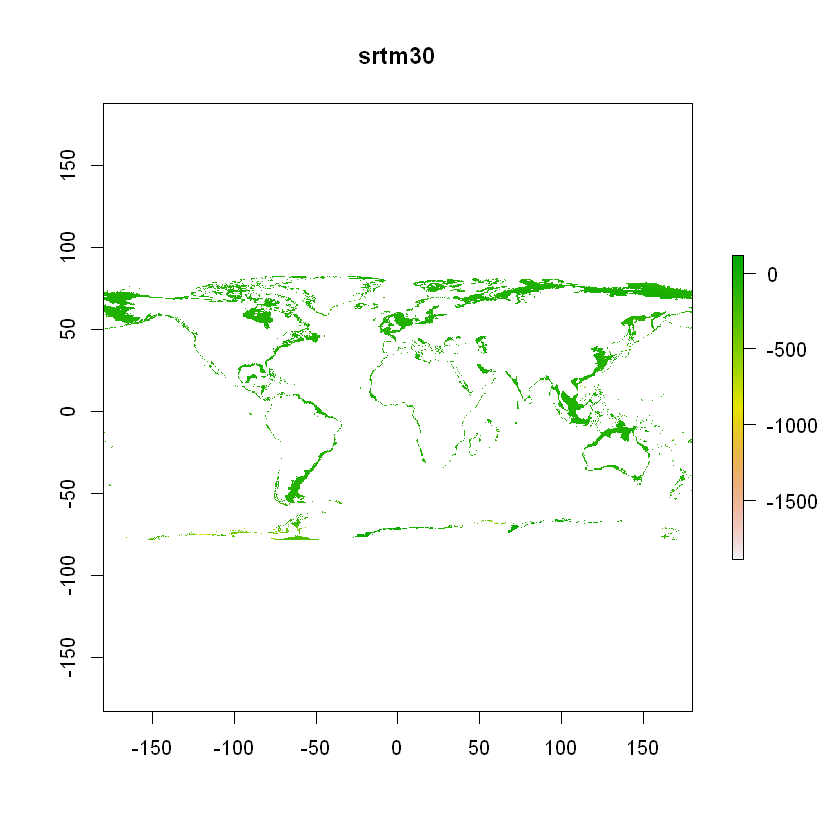

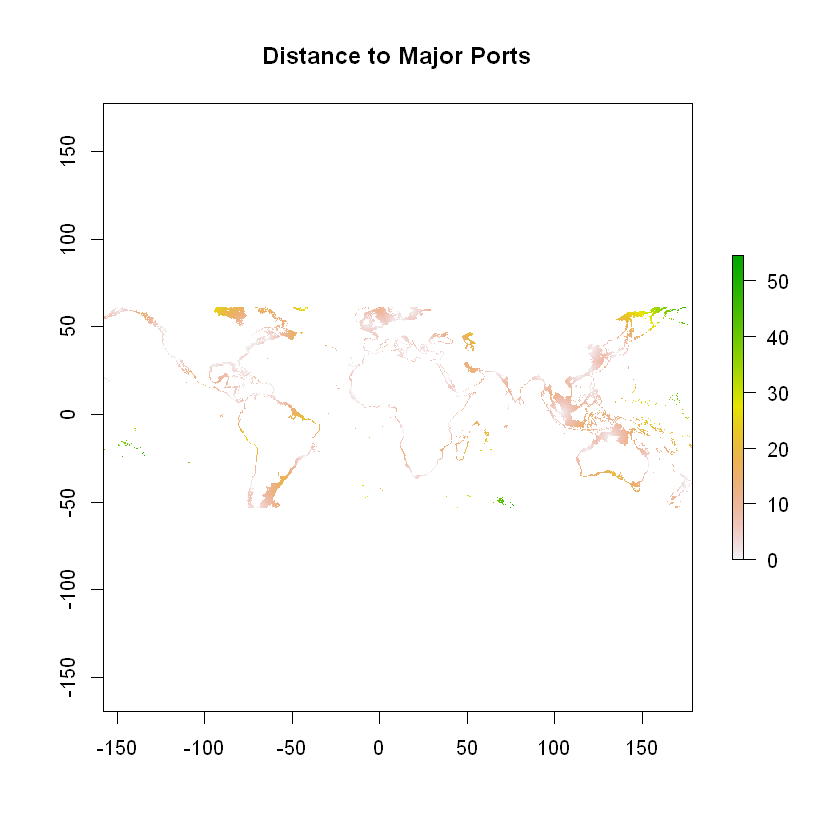

In [58]:
#### A Common Problem with Raster Data: Raster with Different Extents
#### Let's visualize the last raster for environmental variables and the distance raster
plot(raster.obj)
title(main=tail(predictor.names, n=1))

plot(dist.raster.obj)
title(main="Distance to Major Ports")
#### Note that the Distance to Major Ports has a smaller extent
####


In [59]:
raster.arc$extent
dist.raster.arc$extent

xmin    ymin    xmax    ymax 
-180.00  -78.00  180.00   83.25

xmin       ymin       xmax       ymax 
-158.10254  -53.39714  178.70251   61.46436

xmin    ymin    xmax    ymax 
-180.00  -78.00  180.00   83.25

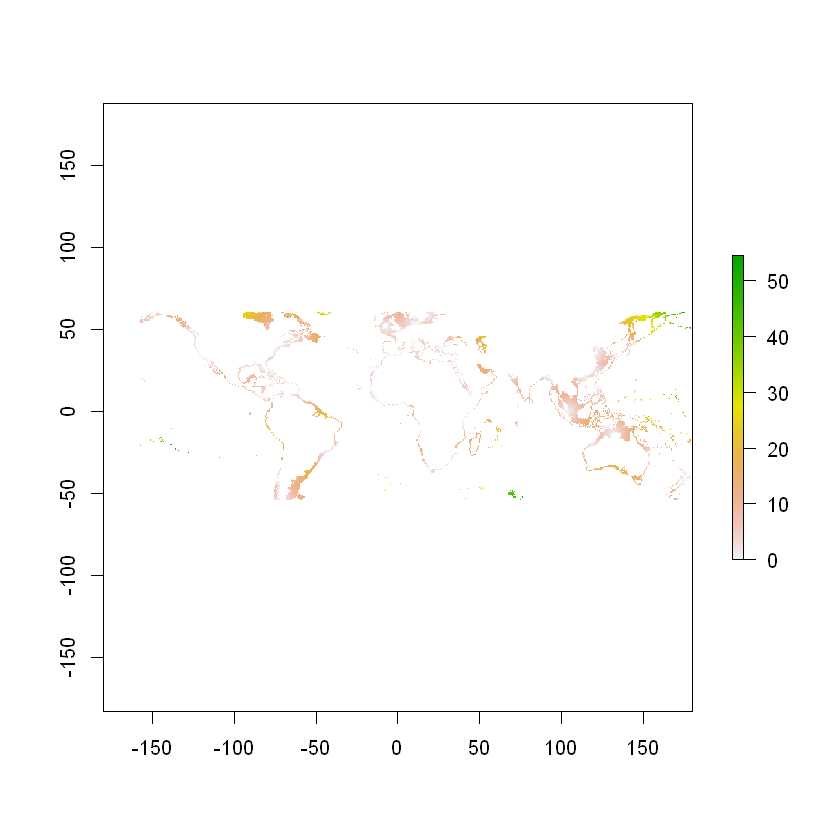

In [60]:
#### The easiest way to solve this problem is to set the Extent of one raster to the other. You can clip all environmental variables to the distance raster or set the distance raster 
#### extent in the R object to that of environmental variables. R-ArcGIS Bridge automatically defines cells with nulls at these locations.
#### Change Rasters Extent On-the-Fly with the R-ArcGIS Bridge
dist.raster.arc <- arc.raster(dist.raster.open.obj, extent = raster.arc$extent, nrow = raster.arc$nrow, ncol = raster.arc$ncol)
dist.raster.obj <- as.raster(dist.raster.arc)
dist.raster.arc$extent
plot(dist.raster.obj)

#### Note that the raster looks the same but now it is populated with NaN's in places that do not have data

In [61]:
raster.stack <- append(raster.stack, dist.raster.obj)
#### Update the predictor names
predictor.names <- append(predictor.names, 'dist2Port')
predictor.names

[1] "temp"      "salinity"  "appO2ut"   "dissO2"    "nitrate"   "percO2sat"
 [7] "phosphate" "silicate"  "srtm30"    "dist2Port"

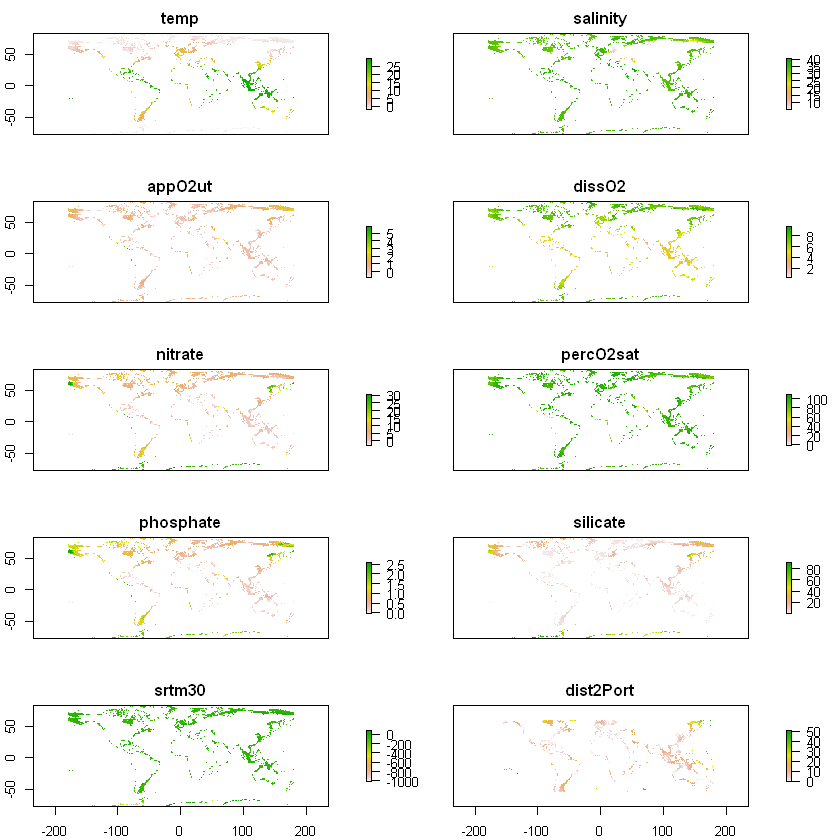

In [68]:
## Plot all of the interpolated rasters
### Stack all rasters for plotting 
rasters <- stack(raster.stack)
### Set Generic Band Names to Predictor Names
names(rasters) <- predictor.names
### Plot Multi-Dimensional Raster
plot(rasters, nc = 2, nr = 5)

In [69]:
## Create Randomly sampled occurence locations within seagrass occurence polygons
seagrass.occurence <- ARCPY$management$CreateRandomPoints("in_memory", "seagrass_occurence", "Seagrass_USA", "0 0 250 250", 100, "0 DecimalDegrees", "POINT", 0)
## Bring in Sampled Location Occurence Using R-ArcGIS Bridge
seagrass.open.obj <- arc.open(toString(seagrass.occurence))
seagrass.arc.data <- arc.select(seagrass.open.obj)
seagrass.sp.data <- arc.data2sp(seagrass.arc.data)
seagrass.locations <- seagrass.sp.data@coords


We need to clip rasters for training a MaxEnt model to the United States coast as our presence data is from U.S. coast. Using global rasters with United States presence data will result in spatially extensive non-presence (not necessarily absence) that will bias the MaxEnt model towards predicting low probability of presence.

We will use the `crop` function in `raster` package to crop the `rasterStack` object that consists of global prediction rasters.

In [106]:
#### Gert the extent for United States Coast using Seagrass Presence polygons as they span the Lower 48 coast
seagrass_poly.loc <- here("R-Bridge-Tutorial-Notebooks/data", gdb.name, 'Seagrass_USA')
seagrass.presence.obj <- arc.open(seagrass_poly.loc)
seagrass.presence.arc <- arc.select(seagrass.presence.obj)
seagrass.presence.data <- arc.data2sp(seagrass.presence.arc)
coast.extent <- extent(seagrass.presence.data)
coast.extent

class       : Extent 
xmin        : -124.8707 
xmax        : -69.8313 
ymin        : 24.43068 
ymax        : 49.07445 

class       : RasterStack 
dimensions  : 98, 220, 21560, 10  (nrow, ncol, ncell, nlayers)
resolution  : 0.25, 0.25  (x, y)
extent      : -124.75, -69.75, 24.5, 49  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
names       :          temp,      salinity,       appO2ut,        dissO2,       nitrate,     percO2sat,     phosphate,      silicate,        srtm30,     dist2Port 
min values  :    4.27007961,   29.98438454,   -0.31230503,    2.75722837,    0.16235784,   52.70940399,    0.02760151,    0.77095008, -120.58560944,    0.00000000 
max values  :     27.047777,     36.494427,      2.603469,      7.122423,     15.511662,    106.771881,      1.803866,     27.971928,     14.677520,     12.657021 


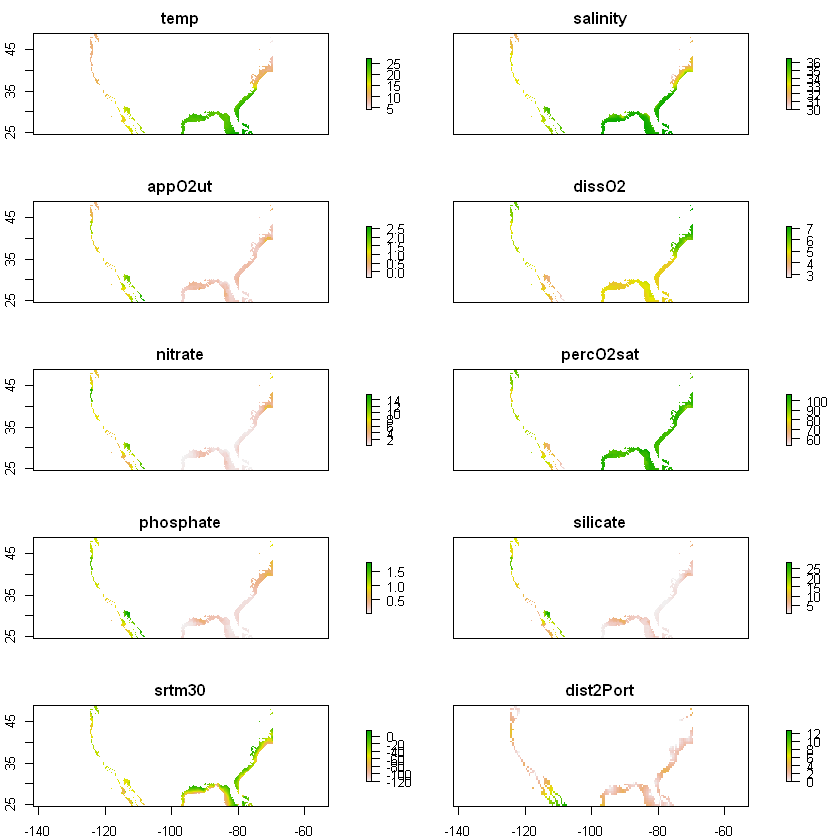

In [111]:
rasters.US.coast <- stack(crop(rasters, coast.extent))
#### Plot Rasters Around U.S. Coast
plot(rasters.US.coast, nc = 2, nr = 5)

In [117]:
seagrass.maxEnt.model <- maxlike(~temp + salinity + appO2ut + dissO2+ nitrate +
percO2sat + phosphate + silicate + srtm30 + dist2Port, rasters.US.coast, seagrass.locations,
method="BFGS", link = "cloglog", removeDuplicates=TRUE, savedata=TRUE)


Warning message in maxlike(~temp + salinity + appO2ut + dissO2 + nitrate + percO2sat + :
"106 points removed due to missing values"

In [118]:
summary(seagrass.maxEnt.model)


Call: maxlike(formula = ~temp + salinity + appO2ut + dissO2 + nitrate +  
    percO2sat + phosphate + silicate + srtm30 + dist2Port, rasters = rasters.US.coast,  
    points = seagrass.locations, link = "cloglog", removeDuplicates = TRUE,  
    savedata = TRUE, method = "BFGS") 

Coefficients:
                 Est       SE        z  P(>|z|)
(Intercept)   1.4176 148.6744  0.00953 9.92e-01
temp         -2.2651   0.6005 -3.77184 1.62e-04
salinity    -12.2761   3.2055 -3.82965 1.28e-04
appO2ut      32.7006  20.6706  1.58199 1.14e-01
dissO2      -54.9699  12.1236 -4.53413 5.78e-06
nitrate      13.4053   3.2208  4.16211 3.15e-05
percO2sat     7.6150   1.9016  4.00445 6.22e-05
phosphate   -43.8100  13.8465 -3.16397 1.56e-03
silicate     -0.7497   0.3921 -1.91223 5.58e-02
srtm30       -0.0102   0.0311 -0.32823 7.43e-01
dist2Port    -3.5227   0.9230 -3.81647 1.35e-04

optim convergence code: 0 

AIC: 1990.541 



In [119]:
confint(seagrass.maxEnt.model)

,2.5 %,97.5 %
(Intercept),-289.97892931,292.81414515
temp,-3.44204980,-1.08806307
salinity,-18.55881713,-5.99334854
appO2ut,-7.81293948,73.21416292
dissO2,-78.73173591,-31.20816076
nitrate,7.09264196,19.71791869
percO2sat,3.88784722,11.34210016
phosphate,-70.94869944,-16.67129664
silicate,-1.51814963,0.01871650
srtm30,-0.07123644,0.05079915


In [120]:
US.prediction <- predict(seagrass.maxEnt.model)

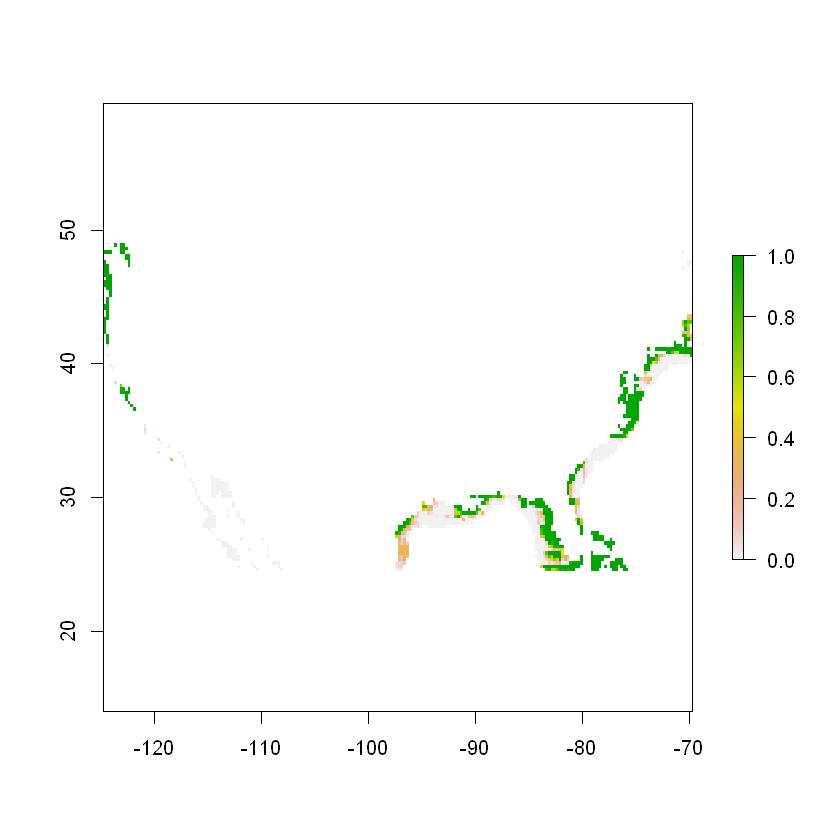

In [121]:
plot(US.prediction)

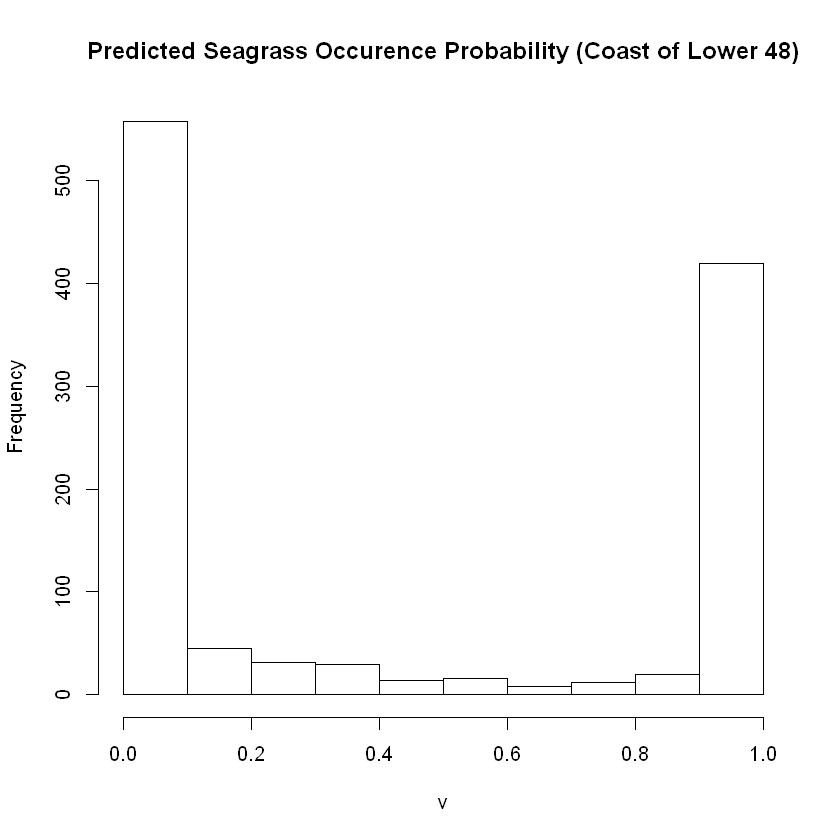

In [136]:
hist(US.prediction, main = 'Predicted Seagrass Occurence Probability (Coast of Lower 48)')

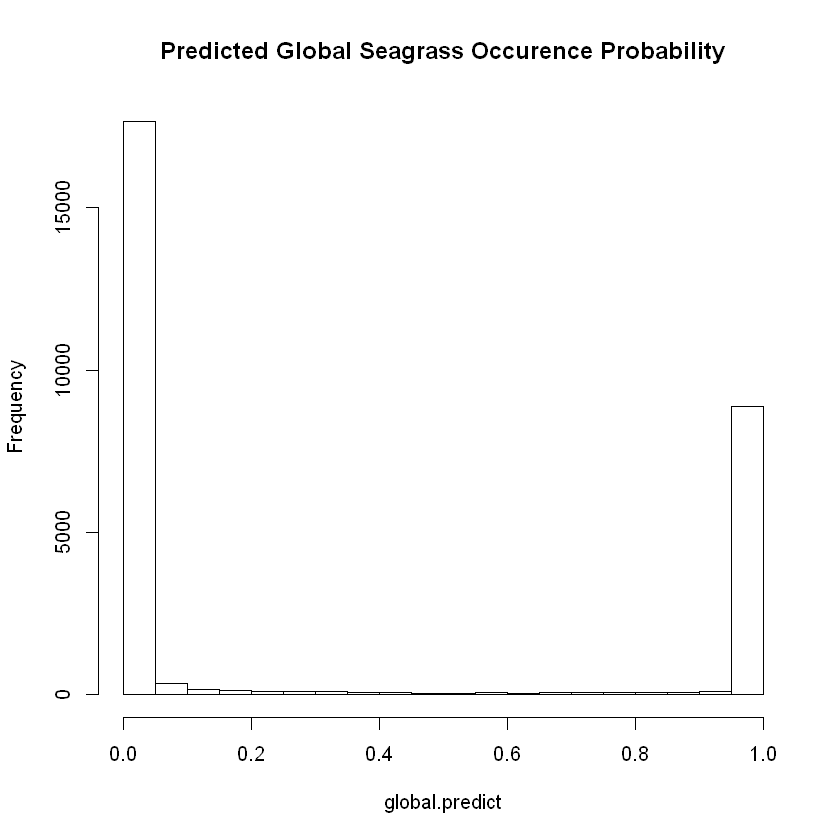

In [138]:
global.predict <- predict(seagrass.maxEnt.model, as.data.frame(rasters))
hist(global.predict, main = 'Predicted Global Seagrass Occurence Probability')

In [142]:
## Create a New Raster that coantains MaxEnt Predictions
##### Define the location to write predictions
write.loc <- here("R-Bridge-Tutorial-Notebooks/data", gdb.name, 'maxEnt_Prediction')
##### Create a Blank Raster that has the same properties as one of the environmental rasters
prediction.raster <- arc.raster(NULL, path = write.loc, 
                                dim = c(raster.arc$nrow, raster.arc$ncol),
                                pixel_type = raster.arc$pixel_type, 
                                sr = raster.arc$sr$WKID,
                                extent = raster.arc$extent)
#### Use an R-ArcGIS Bridge Raster Utility function to push data into blank raster
prediction.raster$write_pixel_block(global.predict, nrow = raster.arc$nrow, ncol = raster.arc$ncol)
#### Write Out the In-Memory Raster
dummy <- prediction.raster$commit()
#### Delete the In-Memory Feature to Avoid Corruption
rm(prediction.raster)

In [5]:
library(arcgisbinding)
library(reticulate)
library(htmlwidgets)
library(IRdisplay)
library(leaflet.esri)
library(leaflet)

In [21]:
m<- leaflet() %>%
  addEsriBasemapLayer(esriBasemapLayers$Streets) %>%
  setView(-122.300, 47.575, 10) %>%
  addEsriFeatureLayer(
    url='https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/King_County_Housing_Prices_Subset/FeatureServer/0',
    useServiceSymbology = TRUE,
    labelProperty = 'price', labelOptions=labelOptions(textsize = '12px'),
    popupProperty = JS("function(feature) { return L.Util.template('<h3>King County House Sales</h3><hr /><p>This house located in zip code {zipcode} was sold for ${price}.', feature.properties);}"))

saveWidget(m, 'demo.html', selfcontained = FALSE)
display_html('<iframe src="demo.html" width=1280, height=860></iframe>')